#### 가우스 잡음

▶ 인코더 : 정보 압축 및 특징 추출
- 입력 데이터에서 중요한 정보(핵심 특징)만 남기고 불필요한 정보는 걸러내면서 데이터를 저차원의 작은 데이터로 압축
- 노이즈 제거에서의 역할 : '노이즈'는 불필요한 정보로 판단하여 버리고, '숫자의 형태'와 같은 핵심 특징만 압축

▶ 디코더 : 정보 복원 및 생성
- 인코더가 만든 압축된 핵심 특징을 입력으로 받아 원래의 데이터 형태로 다시 복원
- 업샘플링이나 전치 합성곱을 통해 데이터 크기를 점차 늘려나간다
- 노이즈 제거에서의 역할 : 인코더로부터 숫자의 형태라는 핵심 특징만 전달받은 디코더는, 이 정보를 바탕으로 노이즈가 없는 꺠끗한 이미지를 그려내도록(복원하도록) 학습

In [6]:
# 가우스 잡음 추가 함수
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision.datasets.mnist import MNIST
from torchvision.transforms import ToTensor

# 가우스노이즈
# noisy_pixel= orginal_pixel + N(u=0, e = scale)
# 평균 = 0 : 픽셀을 전체적으로 밝히거나 어둡게 하지 않음
# 표준편차 = scale -> 값이 클수록 노이즈가 강해짐
# 0.8 -> 노이즈의 양이 많고 숫자 일부를 흐릿하게 한다

In [ ]:
def gaussian_noise(x,scale=0.6):
    gaussian_data_x = np.random.normal(
        loc = 0, scale = scale, size = x.shape      # 평균(loc) 0, 표준편차(scale) scale 값을 갖는 정규분포(가우시안) 노이즈를 생성
    )
    gaussian_data_x = np.clip(gaussian_data_x,0,1)      # 이미지픽셀의 값을 0과 1 사이로 정규화
    gaussian_data_x = torch.tensor(gaussian_data_x,dtype=torch.float32)
    return gaussian_data_x

In [7]:
training_data = MNIST(root='./',train= True, download=True, transform= ToTensor())
test_data = MNIST(root='./',train= False, download=True, transform= ToTensor())


Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:02<00:00, 4.63MB/s]


Extracting ./MNIST\raw\train-images-idx3-ubyte.gz to ./MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 96.6kB/s]


Extracting ./MNIST\raw\train-labels-idx1-ubyte.gz to ./MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:01<00:00, 1.38MB/s]


Extracting ./MNIST\raw\t10k-images-idx3-ubyte.gz to ./MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 11.9kB/s]


Extracting ./MNIST\raw\t10k-labels-idx1-ubyte.gz to ./MNIST\raw



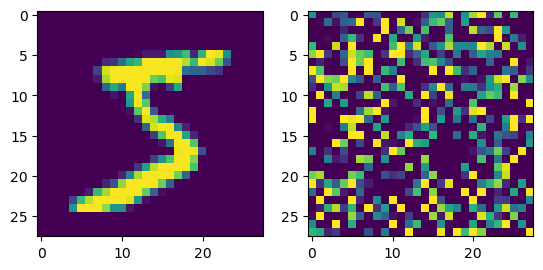

In [ ]:
img,iable = next(iter(training_data))
gaussian = gaussian_noise(img)
img = img.permute(1,2,0)
gaussian = gaussian.permute(1,2,0)


plt.subplot(1,2,1)
plt.imshow(img)
plt.subplot(1,2,2)
plt.imshow(gaussian)
plt.show()

In [ ]:
# 데이터 형식 검증용
for data, label in training_data:
    noisy = gaussian_noise(data)
    print(type(noisy), noisy.size())
    break

<class 'torch.Tensor'> torch.Size([1, 28, 28])


In [ ]:
# 학습용 데이터셋
from torch.utils.data.dataset import Dataset
class Denoise(Dataset):
    def __init__(self):
        self.mnist = MNIST(root='./',train= True, download=True, transform= ToTensor())
        self.data = []
        # 잡음 입히기
        for data,label in self.mnist:
            noisy = gaussian_noise(data)        # 데이터를 0~1사이로 맞춤
            self.data.append(noisy) # (1,1,28,28)   # (배치사이즈, 채널, 높이, 너비)

    def __len__(self):
        return len(self.data)
    def __getitem__(self, index):
        data = self.data[index] 
        label = self.mnist.data[index]/255 # 원본이미지도 0~1 정규화
        return data,label


In [49]:

# 합성곱 기본 블럭
import torch.nn as nn
# conv-relu-conv-relu
class BasicBlock(nn.Module):
    def __init__(self, in_channel, out_channel,hidden_channel):
        super(BasicBlock,self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channel, hidden_channel,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_channel, out_channel,kernel_size=3,padding=1),
            nn.ReLU()
        )
    def forward(self,x):
        return self.model(x)

In [50]:

sample_data = torch.randn(1,1,28,28)
sample_model = BasicBlock(1,20,10)
sample_model(sample_data).size()

torch.Size([1, 20, 28, 28])

##### 인코더

In [51]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder,self).__init__()
        self.conv1 = BasicBlock(1,16,16)
        self.conv2 = BasicBlock(16,8,8)
        self.pool = nn.AvgPool2d(2)     # 평균 풀링 계층. 풀링은 이미지의 크기를 절반으로 줄이는 역할
    def forward(self, x):
        x = self.pool(self.conv1(x)) # 1,16,14,41
        out = self.pool(self.conv2(x)) # 1, 8,7,7
        return out

In [52]:
sample_data = torch.randn(1,1,28,28)
temp_encoder = Encoder()
result_encoder = temp_encoder(sample_data)

##### 디코더

In [ ]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder,self).__init__()
        self.conv1 = BasicBlock(8,8,8)
        self.conv2 = BasicBlock(8,16,16)
        # 출력층
        self.conv3 = nn.Conv2d(16,1,kernel_size=3,padding=1)

        # 업샘플링 층
        self.upsampling1 = nn.ConvTranspose2d(8,8,kernel_size=2, stride=2)
        self.upsampling2 = nn.ConvTranspose2d(16,16,kernel_size=2, stride=2)
    def forward(self,x):
        x = self.upsampling1(self.conv1(x))
        x = self.upsampling2(self.conv2(x))
        out = self.conv3(x)
        return out

In [38]:
d = Decoder()
d(result_encoder).size()

torch.Size([1, 1, 28, 28])

In [54]:
# CAE 오토인코더
# 인코더와 디코더를 연결: 인코더의 출력을 디코더의 입력으로 제공
class CAE(nn.Module):
    def __init__(self):
        super(CAE,self).__init__()
        self.enc = Encoder()
        self.dec = Decoder()

    def forward(self,x):
        x = self.enc(x)
        x = self.dec(x)
        return x

In [55]:
from tqdm import tqdm
from torch.utils.data.dataloader import DataLoader
from torch.optim.adam import Adam
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataset = Denoise()
train_loader = DataLoader(train_dataset,batch_size=32)

model = CAE().to(device)
optim = Adam(model.parameters(), lr = 1e-3)

In [58]:

criterian = nn.MSELoss()
for epoch in range(2):
    loop = tqdm(train_loader)
    for data, label in loop:
        optim.zero_grad()
        data,label = data.to(device), label.to(device)
        pred = model(data)
        loss = criterian(pred, label)
        loss.backward()
        optim.step()

        loop.set_postfix({'loss':f'{loss.item():.4f}'})
torch.save(model.state_dict(), 'CAE.pth')

100%|██████████| 1875/1875 [02:21<00:00, 13.26it/s, loss=0.0670]


In [60]:
model.load_state_dict(torch.load('CAE.pth',map_location=device))

C:\Users\SAMSUNG\AppData\Local\Temp\ipykernel_24872\3041475301.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('CAE.pth',map_location=de

<All keys matched successfully>

In [62]:
sample = test_data.data[0]
sample_noise = gaussian_noise(sample).unsqueeze(0)
print(sample_noise.size())
predict = model(sample_noise)
predict = predict.permute(1,2,0)
predict = predict.detach().numpy()

torch.Size([1, 28, 28])


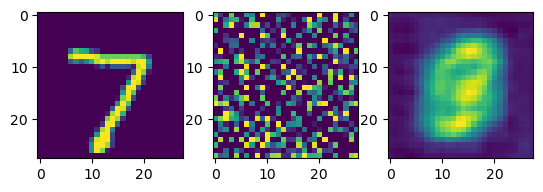

In [66]:
plt.subplot(1,3,1)
plt.imshow(sample)

plt.subplot(1,3,2)
plt.imshow(sample_noise.squeeze(0))

plt.subplot(1,3,3)
plt.imshow(predict)
